## Name: Kevin O'Farrell
## ID:0350869

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer, QuantileTransformer, quantile_transform
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import SVR
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPRegressor

In [2]:
#read the csv and import as pandas dataseries type
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [3]:
df.describe()


age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

In [4]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [5]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)


In [6]:
#Split the data before preprocessing to avoid leakage
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [7]:
Xtrain.boxplot()


<Axes: >

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>, <Axes: >]], dtype=object)

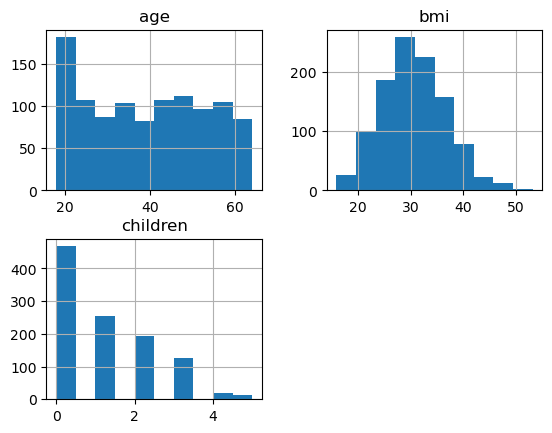

In [8]:
Xtrain.hist()

In [9]:
#group 1
categorical_features = ['gender', 'region']

#group 2 
categorical_features_map = ['smoker']

#group 3
numerical_features = ['age']

#group 3
numerical_features_outliers = ['bmi']

#group 5
numerical_features_standard = ['children']

#function to map yes and no columns to 1 and 0
def binary_mapper(column):
    binary_mapper = {"yes": 1,"no": 0}
    
    return column.replace(binary_mapper)



In [10]:
#make categorical and numerical pipelines for each group of features
categorical_pipeline = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

categorical_pipeline_map = Pipeline(
    steps=[
        ('transform', FunctionTransformer(func=binary_mapper))
    ]
)

numerical_right_skewed_pipeline = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(np.log)),
        ("scaler", StandardScaler())
    ]
)

numerical_outliers_pipeline = Pipeline(
    steps=[
        ("scaler", RobustScaler())
    ]
)

numerical_standard_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)


preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipeline, categorical_features),
        ("categorical_map", categorical_pipeline_map, categorical_features_map),
        ("numerical_right_skewed", numerical_right_skewed_pipeline, numerical_features),
        ("numerical_outliers", numerical_outliers_pipeline, numerical_features_outliers),
        ("numerical_standard", numerical_standard_pipeline, numerical_features_standard)
    ],
    remainder="passthrough"  # there are no remaining columns
)

prepro = preprocess_pipeline.fit(Xtrain)
trans = prepro.transform(Xtrain)
trans


# Create DataFrame with transformed data and column names
trans_df = pd.DataFrame(trans)
trans_df# pipeline with Logistic Regression and PCA




0    1    2    3    4    5    6         7         8         9
0     1.0  0.0  1.0  0.0  0.0  0.0  0.0 -0.102425  0.914370  0.779828
1     1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.360252  0.334222 -0.902462
2     0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.099883  0.167111  0.779828
3     1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.809979 -0.329481 -0.061317
4     0.0  1.0  0.0  0.0  1.0  0.0  0.0 -0.331660  0.805926  0.779828
...   ...  ...  ...  ...  ...  ...  ...       ...       ...       ...
1065  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.006852 -0.324148 -0.061317
1066  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.099883  0.227556  1.620973
1067  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.401182 -0.245333 -0.902462
1068  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.596682 -0.542815  3.303263
1069  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.099883 -0.448000 -0.061317

[1070 rows x 10 columns]

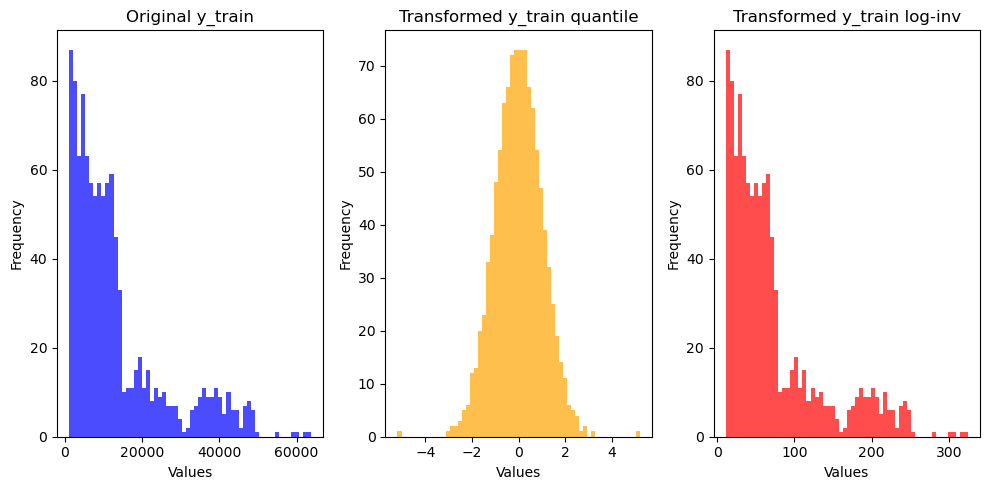

In [11]:
#set the quantile transformer
quantile_transformer = QuantileTransformer(n_quantiles=500, output_distribution='normal')

# ytrain is a 1D series and needs to be reshaped to a 2D array
y_train_2d = ytrain.values.reshape(-1, 1)

# Fit the QuantileTransformer to y_train and transform it
y_train_quantile = quantile_transformer.fit_transform(y_train_2d)

y_train_exp = np.exp((y_train_2d + abs(y_train_2d.min())) / 200)
y_train_log_inv = np.log(y_train_exp)

#plot untransformed y_train
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.hist(ytrain, bins=60, color='blue', alpha=0.7)
plt.title('Original y_train')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Plot transformed y_train quantile
plt.subplot(1, 3, 2)
plt.hist(y_train_quantile, bins=60, color='orange', alpha=0.7)
plt.title('Transformed y_train quantile')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Plot transformed y_train log_inv
plt.subplot(1, 3, 3)
plt.hist(y_train_log_inv, bins=60, color='red', alpha=0.7)
plt.title('Transformed y_train log-inv')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From the above plots its clear that the quantile transformation on the target is a more normal distribution and should give a better result.

#### Start with PCA for dimensionality reduction and a Linear Regression Model

In [12]:
# pipeline with Linear Regression and PCA
pipe_1 = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('pca', PCA()), 
    ('linear', LinearRegression())
])

In [13]:
#Display the pipeline
set_config(display="diagram")
pipe_1

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'region']),
                                                 ('categorical_map',
                                                  Pipeline(steps=[('transform',
                                                                   FunctionTransformer(func=<function binary_mapper at 0x000001F620E6E160>))]),
                                                  ['smoker']),
                                                 ('numerical_right_skewed',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('numerical_outliers',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('numerical_standard',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['children'])])),
                ('pca', PCA()), ('linear', LinearRegression())])

In [14]:
#set the parameters for dim reduction
param_grid_1 = {
    'pca__n_components': [2, 4, 6, 8, 9]
        
}

search_1 = GridSearchCV(pipe_1, param_grid_1, n_jobs=-1, cv=5, refit=True)
search_1.fit(Xtrain, ytrain)

print("Best CV score = %0.3f:" % search_1.best_score_)
print("Best parameters: ", search_1.best_params_)

# store the best params and best model for later use
LR_best_params = search_1.best_params_
LR_best_model = search_1.best_estimator_

Best CV score = 0.740:
Best parameters:  {'pca__n_components': 8}


The r2 score on the training data from cross validation is low at 0.74. Next I will try with another regression model and experiment with dimensionality reduction

#### Create a pipeline with an SVR and Quantile Transformer on the target

In [15]:
# pipeline with Linear Regression and PCA
pipe_2 = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'), 
    ('ttr', TransformedTargetRegressor(regressor=SVR(),
                           transformer=QuantileTransformer(n_quantiles=200, output_distribution="normal")))
        ])

In [16]:
#Display the pipeline
set_config(display="diagram")
pipe_2

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'region']),
                                                 ('categorical_map',
                                                  Pipeline(steps=[('transform',
                                                                   FunctionTransformer(func=<function binary_mapper at 0x000001F620E6E160>))]),
                                                  ['smoker']),
                                                 ('numerical_right_skewed',...
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('numerical_outliers',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('numerical_standard',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['children'])])),
                ('reduce_dim', 'passthrough'),
                ('ttr',
                 TransformedTargetRegressor(regressor=SVR(),
                                            transformer=QuantileTransformer(n_quantiles=200,
                                                                            output_distribution='normal')))])

In [17]:

#set the parameters for the model and dim reduction

param_grid_2 = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': [2, 4, 6, 8, 10],
        'ttr__regressor__C': [1e-1, 1, 10, 12, 15],
        'ttr__regressor__epsilon': [0.05,0.1,0.15,0.17 ],  
        'ttr__regressor__gamma': [0.01, 0.2, 0.1, 1] 
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(RandomForestRegressor(n_estimators=10))],
        'reduce_dim__n_features_to_select': [2, 4, 6, 8, 10],
        'ttr__regressor__C': [1e-1, 1, 10, 12, 15],
        'ttr__regressor__epsilon': [0.1,0.15,0.17],  
        'ttr__regressor__gamma': [0.01, 0.2 ,0.1, 1] 
    }
]

search_2 = GridSearchCV(pipe_2, param_grid_2, n_jobs=-1, cv=5, refit=True)
search_2.fit(Xtrain, ytrain)

print("Best CV score = %0.3f:" % search_2.best_score_)
print("Best parameters: ", search_2.best_params_)

# store the best params and best model for later use
SVR_best_params = search_2.best_params_
SVR_best_model = search_2.best_estimator_

Best CV score = 0.834:
Best parameters:  {'reduce_dim': RFE(estimator=RandomForestRegressor(n_estimators=10), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'ttr__regressor__C': 15, 'ttr__regressor__epsilon': 0.17, 'ttr__regressor__gamma': 0.1}


In [18]:
#Make a pipeline to preprocess, reduce dimensionality and complete the regression step
pipe_3 = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(min_samples_leaf= 4),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [19]:
#set the parameters for the model and dim reduction
param_grid_3 = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': [4, 6, 8, 9, 10],
        'ttr__regressor__n_estimators': [6,8,9],
        'ttr__regressor__max_depth': [4,5,6,7] 
        
    },
    {
        'reduce_dim': [RFE(RandomForestRegressor()),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': [4, 6, 8, 9, 10],
        'ttr__regressor__n_estimators': [6,8,9],
        'ttr__regressor__max_depth': [4,5,6,7]  
        
    }
]

search_3 = GridSearchCV(pipe_3, param_grid_3, n_jobs=-1, cv=5, refit=True)
search_3.fit(Xtrain, ytrain)

print("Best CV score = %0.3f:" % search_3.best_score_)
print("Best parameters: ", search_3.best_params_)

# store the best params and best model for later use
RFR_best_params = search_3.best_params_
RFR_best_model = search_3.best_estimator_

Best CV score = 0.854:
Best parameters:  {'reduce_dim': RFE(estimator=RandomForestRegressor(), n_features_to_select=10), 'reduce_dim__n_features_to_select': 10, 'ttr__regressor__max_depth': 5, 'ttr__regressor__n_estimators': 9}


In [20]:


# Modify the pipeline to include MLPRegressor
pipe_4 = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', 'passthrough'), 
    ('ttr', TransformedTargetRegressor(regressor=MLPRegressor(),
                                       transformer=QuantileTransformer(n_quantiles=200, output_distribution="normal")))
])

param_grid_4 = [ {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': [2, 4, 6, 8, 10],
        'ttr__regressor__hidden_layer_sizes': [(64,), (128, 64), (256, 128, 64)],
        'ttr__regressor__activation': ['relu', 'tanh', 'logistic'],
        'ttr__regressor__alpha': [0.0001, 0.001, 0.01] 
        
    },
    {
        'reduce_dim': [RFE(RandomForestRegressor()),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': [2, 4, 6, 8, 10],
        'ttr__regressor__hidden_layer_sizes': [(64,), (128, 64), (256, 128, 64)],
        'ttr__regressor__activation': ['relu', 'tanh', 'logistic'],
        'ttr__regressor__alpha': [0.0001, 0.001, 0.01]  
        
    }
]
    

search_4 = GridSearchCV(pipe_4, param_grid_4, n_jobs=-1, cv=5, refit=True)
search_4.fit(Xtrain, ytrain)

print("Best CV score = %0.3f:" % search_4.best_score_)
print("Best parameters: ", search_4.best_params_)

# store the best params and best model for later use
MLP_best_params = search_4.best_params_
MLP_best_model = search_4.best_estimator_

Best CV score = 0.835:
Best parameters:  {'reduce_dim': RFE(estimator=RandomForestRegressor(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'ttr__regressor__activation': 'relu', 'ttr__regressor__alpha': 0.01, 'ttr__regressor__hidden_layer_sizes': (128, 64)}


In [21]:
#Evaluate the model on the test data using regression metrics
def evaluate_model(X_test, y_test, model):

    
    # compute prediction for the test set
    _predicted_values = model.predict(Xtest)
        
    # compute metrics
    _mse = mean_squared_error(ytest, _predicted_values)
    _mae = mean_absolute_error(ytest, _predicted_values)
    _r2 = r2_score(ytest, _predicted_values)
            
    return _mse, _mae, _r2



In [22]:
#call the evaluate function for the three regression models
LR_mse, LR_mae, LR_r2 = evaluate_model(Xtest, ytest, LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(Xtest, ytest, RFR_best_model)
RFR_mse, RFR_mae, RFR_r2 = evaluate_model(Xtest, ytest, SVR_best_model)
MLP_mse, MLP_mae, MLP_r2 = evaluate_model(Xtest, ytest, MLP_best_model)
#print the results of each models regression metrics
print(f'Random Forest Resgressor MSE: {RFR_mse:.2f}\nRandom Forest Regressor MAE: {RFR_mae:.2f}\nRandom Forest Regressor R2: {RFR_r2:.4f}\n')

print(f'Support Vector Regressor MSE: {SVR_mse:.2f}\nSupport Vector Regressor MAE: {SVR_mae:.2f}\nSupport Vector Regressor R2: {SVR_r2:.4f}\n')

print(f'Linear Regression MSE: {LR_mse:.2f}\nLinear Regression MAE: {LR_mae:.2f}\nLinear Regression R2: {LR_r2:.4f}\n')

print(f'MLP Regression MSE: {MLP_mse:.2f}\nMLP Regression MAE: {MLP_mae:.2f}\nMLP Regression R2: {MLP_r2:.4f}\n')

Random Forest Resgressor MSE: 19547770.75
Random Forest Regressor MAE: 2263.38
Random Forest Regressor R2: 0.8616

Support Vector Regressor MSE: 17187685.60
Support Vector Regressor MAE: 2037.67
Support Vector Regressor R2: 0.8783

Linear Regression MSE: 37271016.50
Linear Regression MAE: 4426.49
Linear Regression R2: 0.7361

MLP Regression MSE: 19113680.93
MLP Regression MAE: 2273.75
MLP Regression R2: 0.8647



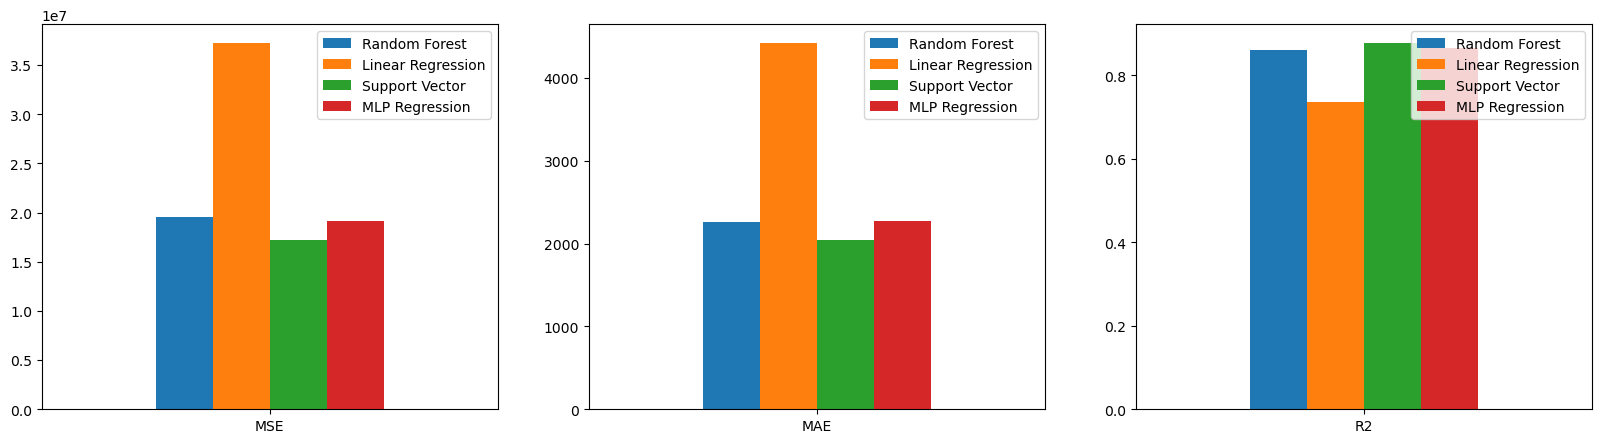

In [24]:
#plot the metrics for each model

df_mse = pd.DataFrame({'Random Forest': RFR_mse, 'Linear Regression': LR_mse, 'Support Vector': SVR_mse, 'MLP Regression': MLP_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RFR_mae, 'Linear Regression': LR_mae, 'Support Vector': SVR_mae, 'MLP Regression': MLP_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RFR_r2, 'Linear Regression': LR_r2, 'Support Vector': SVR_r2, 'MLP Regression': MLP_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])


plt.show()

In [26]:
# function to remove the string 'ttr__regressor__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(
    preprocess_pipeline, 
    RFR_best_params.get('reduce_dim'),
    TransformedTargetRegressor(
        regressor=SVR(**transform(SVR_best_params, 'ttr__regressor__')),
        transformer=QuantileTransformer(n_quantiles=200, output_distribution="normal")
    )
)

final_model = pipe.fit(X, y)

In [27]:
#Sanity check that I trained the model correctly
y_pred = final_model.predict(Xtest)

# Calculate the R^2 score
r2 = r2_score(ytest, y_pred)
print("R^2 Score:", r2)

R^2 Score: 0.8762068698259592


In [28]:
#Save the file to be deployed 
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

#### Summary of experience
The linear regression model was the most basic and there was a lot of variance in the model training (r2 score = 0.74 training, r2 score = 0.736 test). 

I plotted the target and noticed that the data was right skewed. With regression its important to seek a normal distribution on the target as well as the numerical features. I plotted a log and inverse and a quantile transformation. It was clear the quantile transformation gave ytrain a normal distribution. 

I trained an SVM model with quantile transformer and used gridsearch to look for the best dimensionality reduction. The model with SVM regresssor, the target transformed with qunatile and dimensionality with RFE(random forest) seemed to preform the best. It had an r2 score of 0.83 in training and 0.878 on unseen data, meaning it generalised well and didn't overfit. 

The random forest regressor with the same dimensionality and log-inv target transformer performed the best in training with an r2 of 0.853 which was surprising after seeing that log-inv had made little impact on the ytrain from the previous plot. The test data was slightly lower than the SVM model at 0.862.

Lastly I tried and MLP regressor and that performed similarly to the SVM model with good training and test scores.


